<a href="https://colab.research.google.com/github/Jayaprakash1710/Computer-Vision-Ninjacart/blob/main/Ninjacart_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File link: https://drive.google.com/file/d/1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT/view?usp=sharing

In [39]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=5e76cd38-755b-4f26-98bf-ec7bf5fd67be
To: /content/ninjacart_data.zip
100% 275M/275M [00:04<00:00, 65.9MB/s]


In [ ]:
!unzip /content/ninjacart_data.zip

Archive:  /content/ninjacart_data.zip
replace ninjacart_data/test/indian market/bhl.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import random
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

%matplotlib inline

In [ ]:
def visualize_image_counts(dataset_type='train'):
    base_path = '/content/ninjacart_data'
    folder_path = os.path.join(base_path, dataset_type)
    class_counts = {}

    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count

    total_images = sum(class_counts.values())

    # Plotting
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.title(f"Image Count per Class in {dataset_type.capitalize()} Set")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height),
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print class-wise and total count below the plot
    print("\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls} - {count}")
    print(f"Total {dataset_type} images - {total_images}")

In [ ]:
visualize_image_counts('train')

In [ ]:
visualize_image_counts("test")

In [ ]:
def create_validation_split(train_dir='/content/ninjacart_data/train', val_dir='/content/ninjacart_data/val', val_split=0.2):
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_val_path = os.path.join(val_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_val_path, exist_ok=True)

        images = os.listdir(class_train_path)
        random.shuffle(images)

        val_count = int(len(images) * val_split)
        val_images = images[:val_count]

        for img in val_images:
            src_path = os.path.join(class_train_path, img)
            dst_path = os.path.join(class_val_path, img)
            shutil.move(src_path, dst_path)

    print("Validation split created.")

In [ ]:
create_validation_split()

In [ ]:
visualize_image_counts("train")

In [ ]:
visualize_image_counts("val")

In [ ]:
def show_sample_images(train_dir='/content/ninjacart_data/train', samples_per_class=5):
    class_names = sorted(os.listdir(train_dir))
    plt.figure(figsize=(samples_per_class * 3, len(class_names) * 3))

    img_index = 1
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)
        images = images[:samples_per_class]

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w, _ = img.shape

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f"{class_name}\n{w}x{h}")
            img_index += 1

    plt.tight_layout()
    plt.show()

In [ ]:
show_sample_images()

Resizing and Rescaling images:

In [ ]:
def resize_and_rescale(base_path='/content/ninjacart_data', img_size=(224, 224), batch_size=32):
    preprocess = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255)
    ])

    def process(x, y):
        x = preprocess(x)
        y = tf.one_hot(y, depth=4)
        return x, y

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/train',
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names
    train_ds = raw_train_ds.map(process)

    val_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/val',
        image_size=img_size,
        batch_size=batch_size
    ).map(process)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        f'{base_path}/test',
        image_size=img_size,
        batch_size=batch_size
    ).map(process)

    return train_ds, val_ds, test_ds, class_names

In [ ]:
train_ds, val_ds, test_ds,class_names = resize_and_rescale()

#Base Line model

In [ ]:
def baseline(height=224, width=224):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn",
        layers=[
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model = baseline()
model.summary()

In [ ]:
def compile_train_v1(model, train_ds, val_ds, ckpt_path="/tmp/checkpoint.weights.h5"):
    epochs = 10
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [ ]:
model_fit = compile_train_v1(model, train_ds, val_ds)

In [ ]:
def annot_max(x,y, xytext=(0.94,0.96), ax=None, only_y=True):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    if only_y:
        text = "{:.2f}%".format(ymax)
    else:
        text= "x={:.2f}, y={:.2f}%".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=xytext, **kw)

def plot_accuracy(model_fit):
    #accuracy graph
    x = range(0,len(model_fit.history['accuracy']))
    y_train = [acc * 100 for acc in model_fit.history['accuracy']]
    y_val = [acc * 100 for acc in model_fit.history['val_accuracy']]

    plt.plot(x, y_train, label='Train', color='b')
    annot_max(x, y_train, xytext=(0.7,0.9))
    plt.plot(x, y_val, label='Val', color='r')
    annot_max(x, y_val, xytext=(0.8,0.7))
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
plot_accuracy(model_fit)

In [ ]:
def print_accuracy_stats(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)

    test_acc = accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')

# Note: This doesn't work with shuffled datasets
def plot_confusion_matrix(model, ds, class_names):
    model.load_weights("/tmp/checkpoint.weights.h5")
    true_onehot = tf.concat([y for x, y in ds], axis=0)
    true_categories = tf.argmax(true_onehot, axis=1)
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    cm = confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu", fmt='g')
    plt.show()

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-1

In [ ]:
def arch_1(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_1",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", activation='relu', input_shape=(height, width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same", activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same", activation='relu'),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, activation='relu'),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model = arch_1()
model.summary()

In [ ]:
def compile_train_v1(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    ])
    return model_fit

In [ ]:
model_fit = compile_train_v1(model, train_ds, val_ds)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-2

In [ ]:
def arch_2(height=224, width=224):
    num_classes = 4
    hidden_size = 512

    model = keras.Sequential(
        name="model_cnn_2",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=512, kernel_size=3, padding="same"),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model = arch_2()
model.summary()

In [ ]:
model_fit = compile_train_v1(model, train_ds, val_ds, epochs=30)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
def compile_train_v2(model, train_ds, val_ds, epochs=10, ckpt_path="/tmp/checkpoint.weights.h5"):
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.3, patience=10, min_lr=0.00001
        ),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, min_delta=0.001, mode='min'
        )
    ]
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return model_fit

In [ ]:
model = arch_2()
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

In [ ]:
plot_accuracy(model_fit)

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Architecture-3

In [ ]:
def arch_3(height=128, width=128):
    num_classes = 4
    hidden_size = 256

    model = keras.Sequential(
        name="model_cnn_3",
        layers=[
            layers.Conv2D(filters=16, kernel_size=3, padding="same", input_shape=(height, width, 3),
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=32, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=64, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=128, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.MaxPooling2D(),
            layers.Conv2D(filters=256, kernel_size=3, padding="same",
                            kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            # layers.MaxPooling2D(),
            # layers.Flatten(),
            layers.GlobalAveragePooling2D(),
            layers.Dense(units=hidden_size, kernel_regularizer=regularizers.l2(1e-3)),
            layers.Activation("relu"),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(units=num_classes, activation='softmax')
        ]
    )
    return model

In [ ]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.6408 - loss: 1.7529 - val_accuracy: 0.2516 - val_loss: 2.8684 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.7596 - loss: 1.2830 - val_accuracy: 0.3365 - val_loss: 2.5475 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.8131 - loss: 1.0909 - val_accuracy: 0.4567 - val_loss: 1.7832 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8293 - loss: 1.0266 - val_accuracy: 0.5657 - val_loss: 1.5662 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8511 - loss: 0.9474 - val_accuracy: 0.4151 - val_loss: 2.6240 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8461 - loss: 0.8830 - val_accuracy: 0.6410 - val_loss: 1.4470 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8603 - loss: 0.84

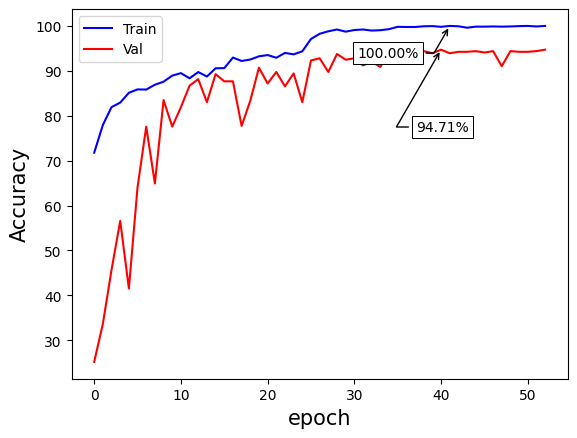

In [ ]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step

Test Accuracy: 21.94%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


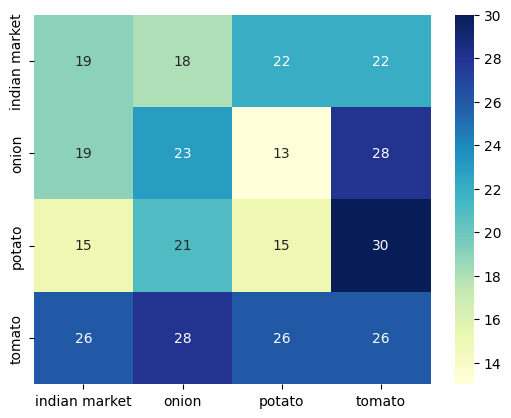

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)

# Data Augmentation

In [ ]:
def get_augmented_train_ds(path, img_size=(128, 128), batch_size=32):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomCrop(img_size[0], img_size[1])
    ])

    raw_train_ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = raw_train_ds.class_names

    augmented_train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x), tf.one_hot(y, depth=len(class_names))))

    return augmented_train_ds, class_names

In [ ]:
train_ds, class_names = get_augmented_train_ds('/content/ninjacart_data/train')

Found 2511 files belonging to 4 classes.


In [ ]:
model = arch_3()
model.summary()

Model: "model_cnn_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 256)            │             

 Total params: 462,436 (1.76 MB)

 Trainable params: 460,932 (1.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
model_fit = compile_train_v2(model, train_ds, val_ds, epochs=100)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.2550 - loss: 2.6888 - val_accuracy: 0.2147 - val_loss: 1.9587 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.2416 - loss: 2.4739 - val_accuracy: 0.2708 - val_loss: 1.9796 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.2577 - loss: 2.3109 - val_accuracy: 0.2516 - val_loss: 2.1684 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.3296 - loss: 2.1048 - val_accuracy: 0.3558 - val_loss: 1.8199 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.3763 - loss: 1.9259 - val_accuracy: 0.3077 - val_loss: 1.7792 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.3207 - loss: 2.0352 - val_accuracy: 0.4071 - val_loss: 1.8699 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.2722 - l

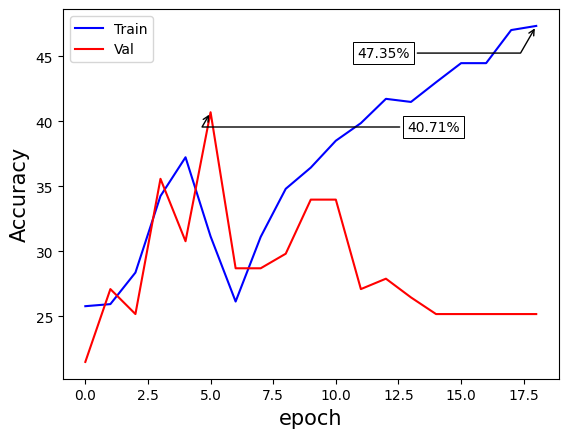

In [ ]:
plot_accuracy(model_fit)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

Test Accuracy: 23.65%

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


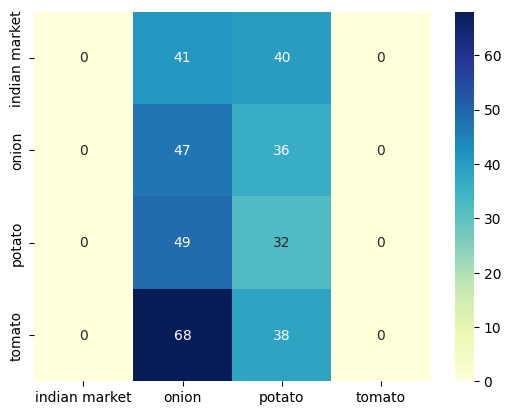

In [ ]:
print_accuracy_stats(model, test_ds, class_names)
plot_confusion_matrix(model, test_ds, class_names)